# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [4]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [5]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


# Model

In [6]:
conv_base = InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 1536))
test_features = np.reshape(test_features, (-1, 8 * 8 * 1536))

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_InceptionResNetV2_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_InceptionResNetV2_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 236 samples, validate on 50 samples
Epoch 1/1000
 - 1s - loss: 0.1067 - acc: 0.9449 - val_loss: 0.0036 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00356, saving model to tl_freeze_conv_base_InceptionResNetV2_2_breeds
Epoch 2/1000
 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 9.9537e-04 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00356 to 0.00100, saving model to tl_freeze_conv_base_InceptionResNetV2_2_breeds
Epoch 3/1000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 5.9136e-04 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00100 to 0.00059, saving model to tl_freeze_conv_base_InceptionResNetV2_2_breeds
Epoch 4/1000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 3.3282e-04 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00059 to 0.00033, saving model to tl_freeze_conv_base_InceptionResNetV2_2_breeds
Epoch 5/1000
 - 0s - loss: 5.5316e-04 - acc: 1.0000 - val_loss: 1.9892e-04 - val_acc: 1.0000

Epoch 00005: val_loss improved fr

## Results

In [10]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 1ms/step


[4.266964835291365e-06, 1.0]

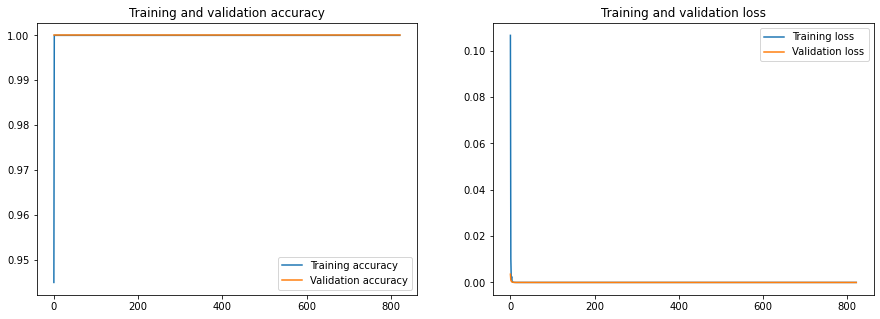

In [11]:
plot_accuracy_and_loss(history)

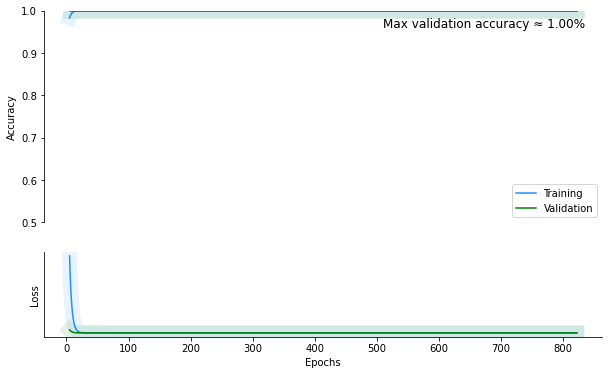

In [12]:
plot_history(history,xkcd=False)

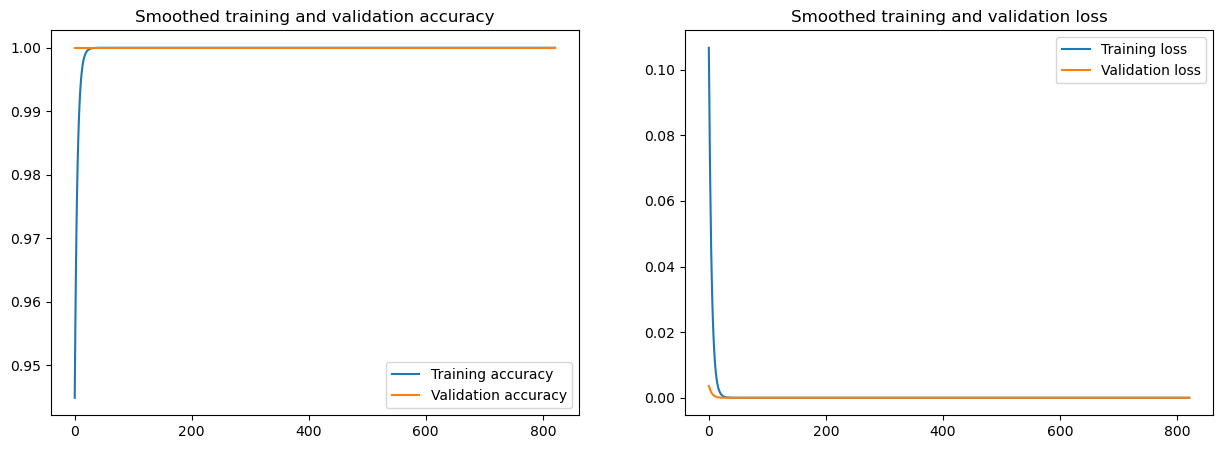

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [24]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


## Model

In [25]:
conv_base = InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [16]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
________________________________________________________________________________

In [26]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 1536))
test_features = np.reshape(test_features, (-1, 8 * 8 * 1536))

In [27]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_InceptionResNetV2_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_InceptionResNetV2_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 412 samples, validate on 88 samples
Epoch 1/1000
 - 1s - loss: 0.1851 - acc: 0.9442 - val_loss: 0.0063 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00627, saving model to tl_freeze_conv_base_InceptionResNetV2_3_breeds
Epoch 2/1000
 - 1s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00627 to 0.00321, saving model to tl_freeze_conv_base_InceptionResNetV2_3_breeds
Epoch 3/1000
 - 1s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00321 to 0.00223, saving model to tl_freeze_conv_base_InceptionResNetV2_3_breeds
Epoch 4/1000
 - 1s - loss: 6.1260e-04 - acc: 1.0000 - val_loss: 9.3259e-04 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00223 to 0.00093, saving model to tl_freeze_conv_base_InceptionResNetV2_3_breeds
Epoch 5/1000
 - 1s - loss: 2.8084e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000

Epoch 00005: val_loss did not improve fro

## Results

In [28]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 0s 944us/step


[0.01215576709069011, 0.9887640476226807]

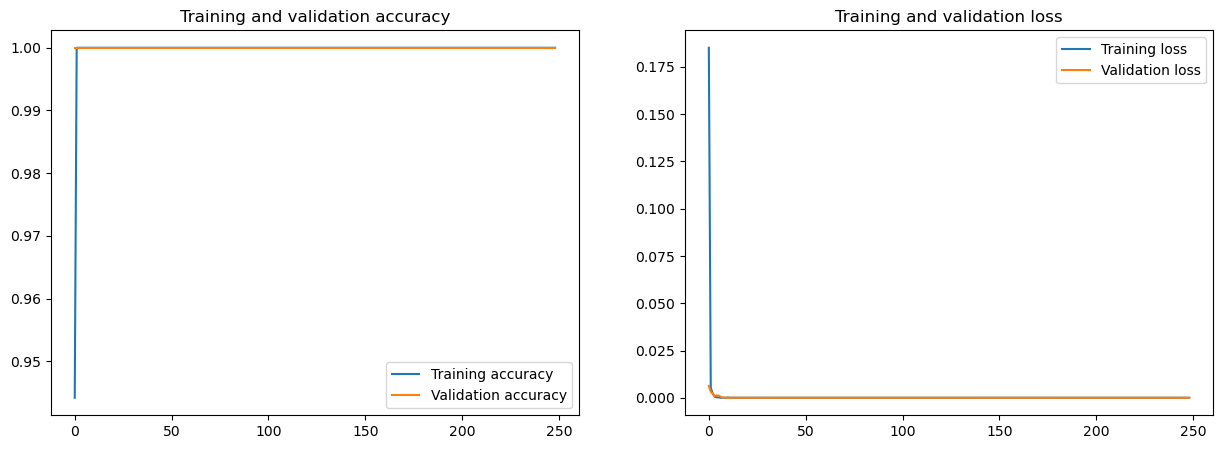

In [29]:
plot_accuracy_and_loss(history)

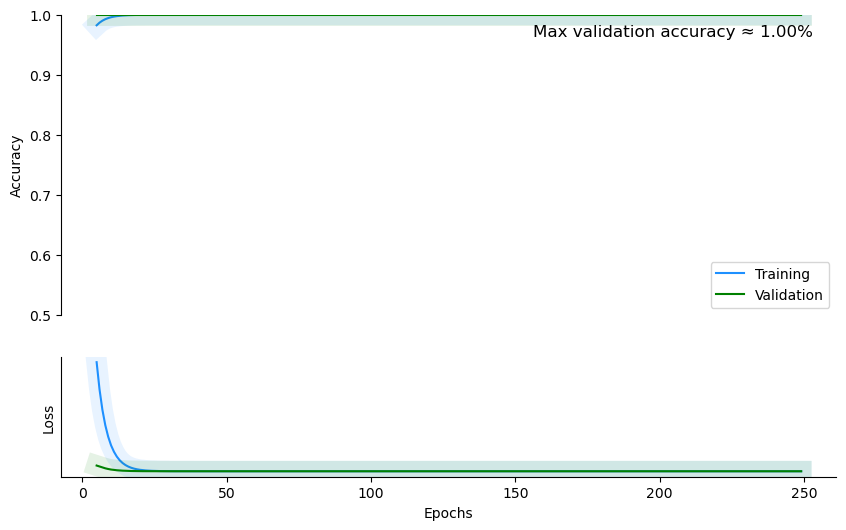

In [30]:
plot_history(history,xkcd=False)

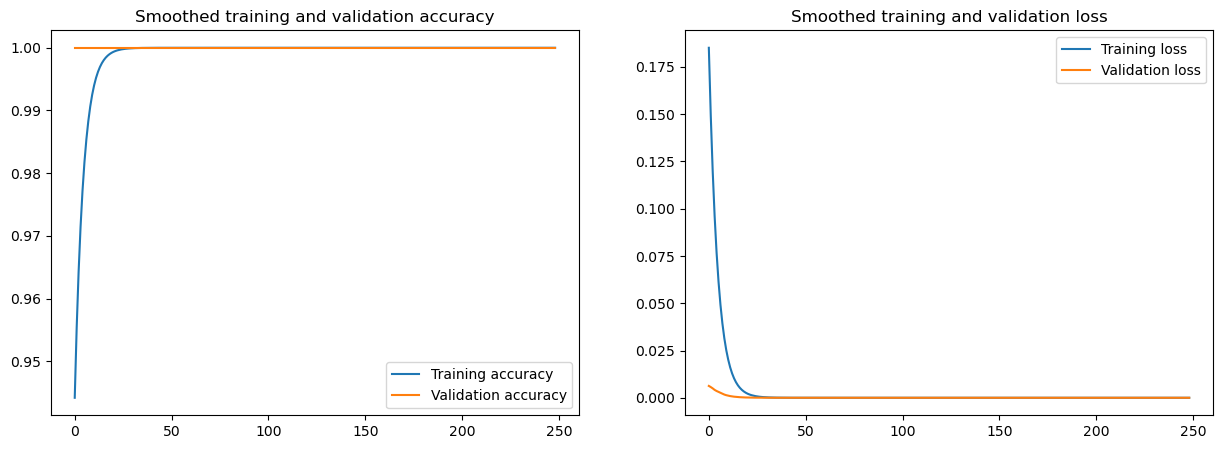

In [31]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

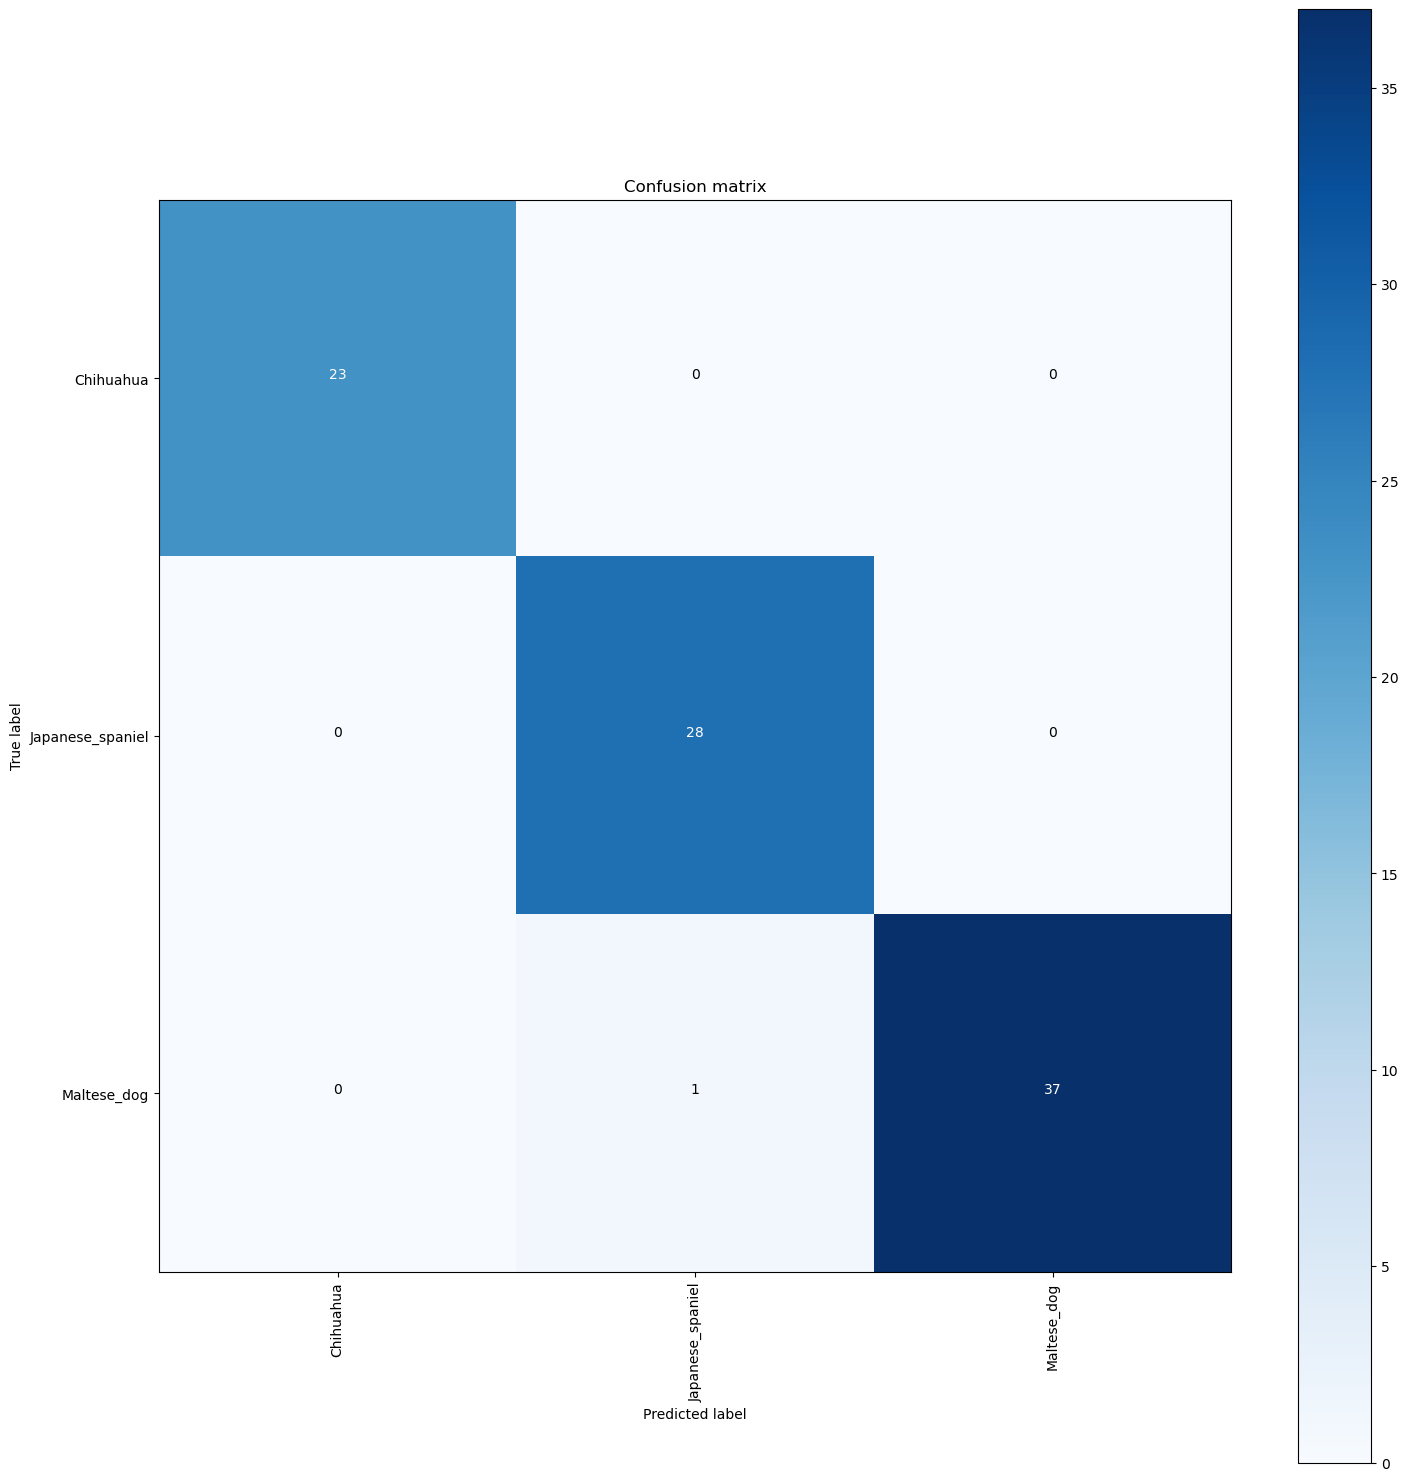

In [32]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [33]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


## Model

In [42]:
conv_base = InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [35]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_610 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, 149, 149, 32) 96          conv2d_610[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 149, 149, 32) 0           batch_normalization_610[0][0]    
________________________________________________________________________________

In [43]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 1536))
test_features = np.reshape(test_features, (-1, 8 * 8 * 1536))

In [44]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_InceptionResNetV2_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_InceptionResNetV2_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 666 samples, validate on 143 samples
Epoch 1/1000
 - 1s - loss: 0.3478 - acc: 0.8994 - val_loss: 0.1320 - val_acc: 0.9510

Epoch 00001: val_loss improved from inf to 0.13201, saving model to tl_freeze_conv_base_InceptionResNetV2_5_breeds
Epoch 2/1000
 - 1s - loss: 0.0834 - acc: 0.9775 - val_loss: 0.0844 - val_acc: 0.9790

Epoch 00002: val_loss improved from 0.13201 to 0.08444, saving model to tl_freeze_conv_base_InceptionResNetV2_5_breeds
Epoch 3/1000
 - 1s - loss: 0.0545 - acc: 0.9820 - val_loss: 0.1907 - val_acc: 0.9650

Epoch 00003: val_loss did not improve from 0.08444
Epoch 4/1000
 - 1s - loss: 0.0313 - acc: 0.9910 - val_loss: 0.0668 - val_acc: 0.9790

Epoch 00004: val_loss improved from 0.08444 to 0.06676, saving model to tl_freeze_conv_base_InceptionResNetV2_5_breeds
Epoch 5/1000
 - 1s - loss: 0.0143 - acc: 0.9925 - val_loss: 0.1115 - val_acc: 0.9790

Epoch 00005: val_loss did not improve from 0.06676
Epoch 6/1000
 - 1s - loss: 0.0096 - acc: 0.9970 - val_loss: 0.1163 - 

## Results

In [45]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 0s 902us/step


[0.10978205015719421, 0.9720279574394226]

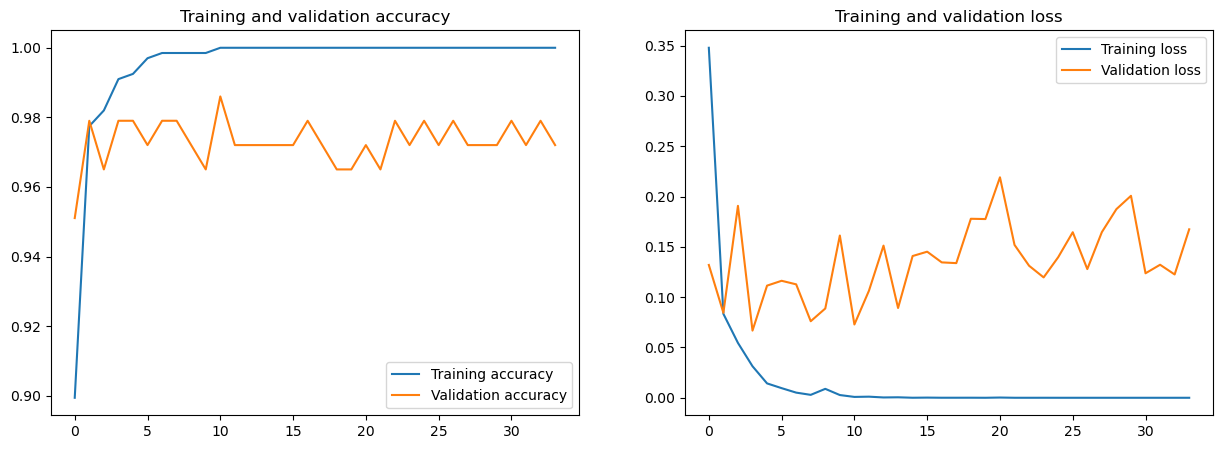

In [46]:
plot_accuracy_and_loss(history)

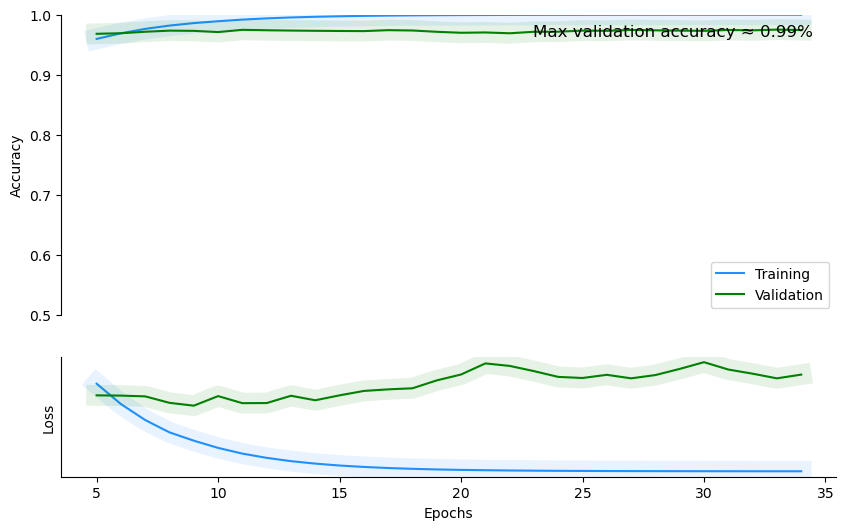

In [47]:
plot_history(history,xkcd=False)

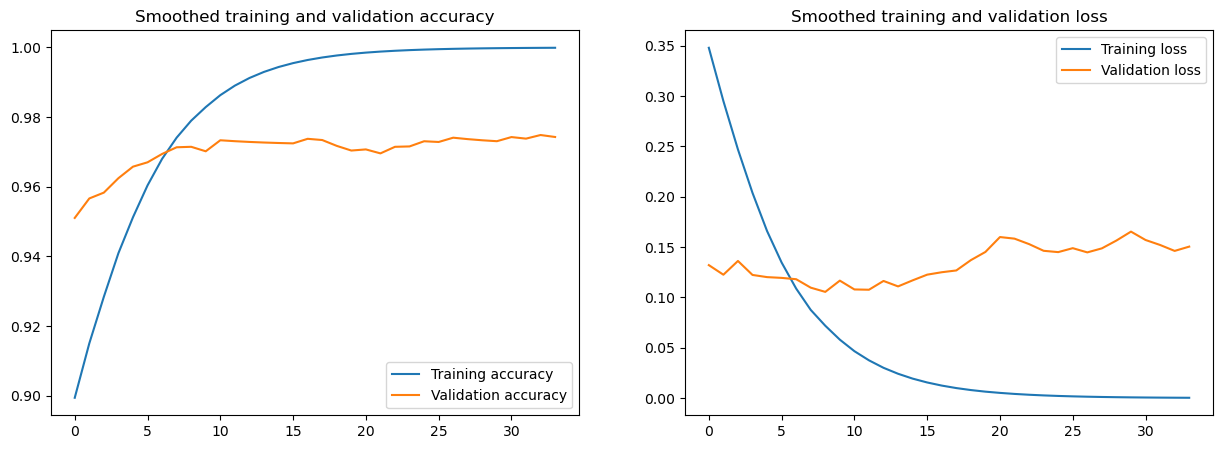

In [48]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

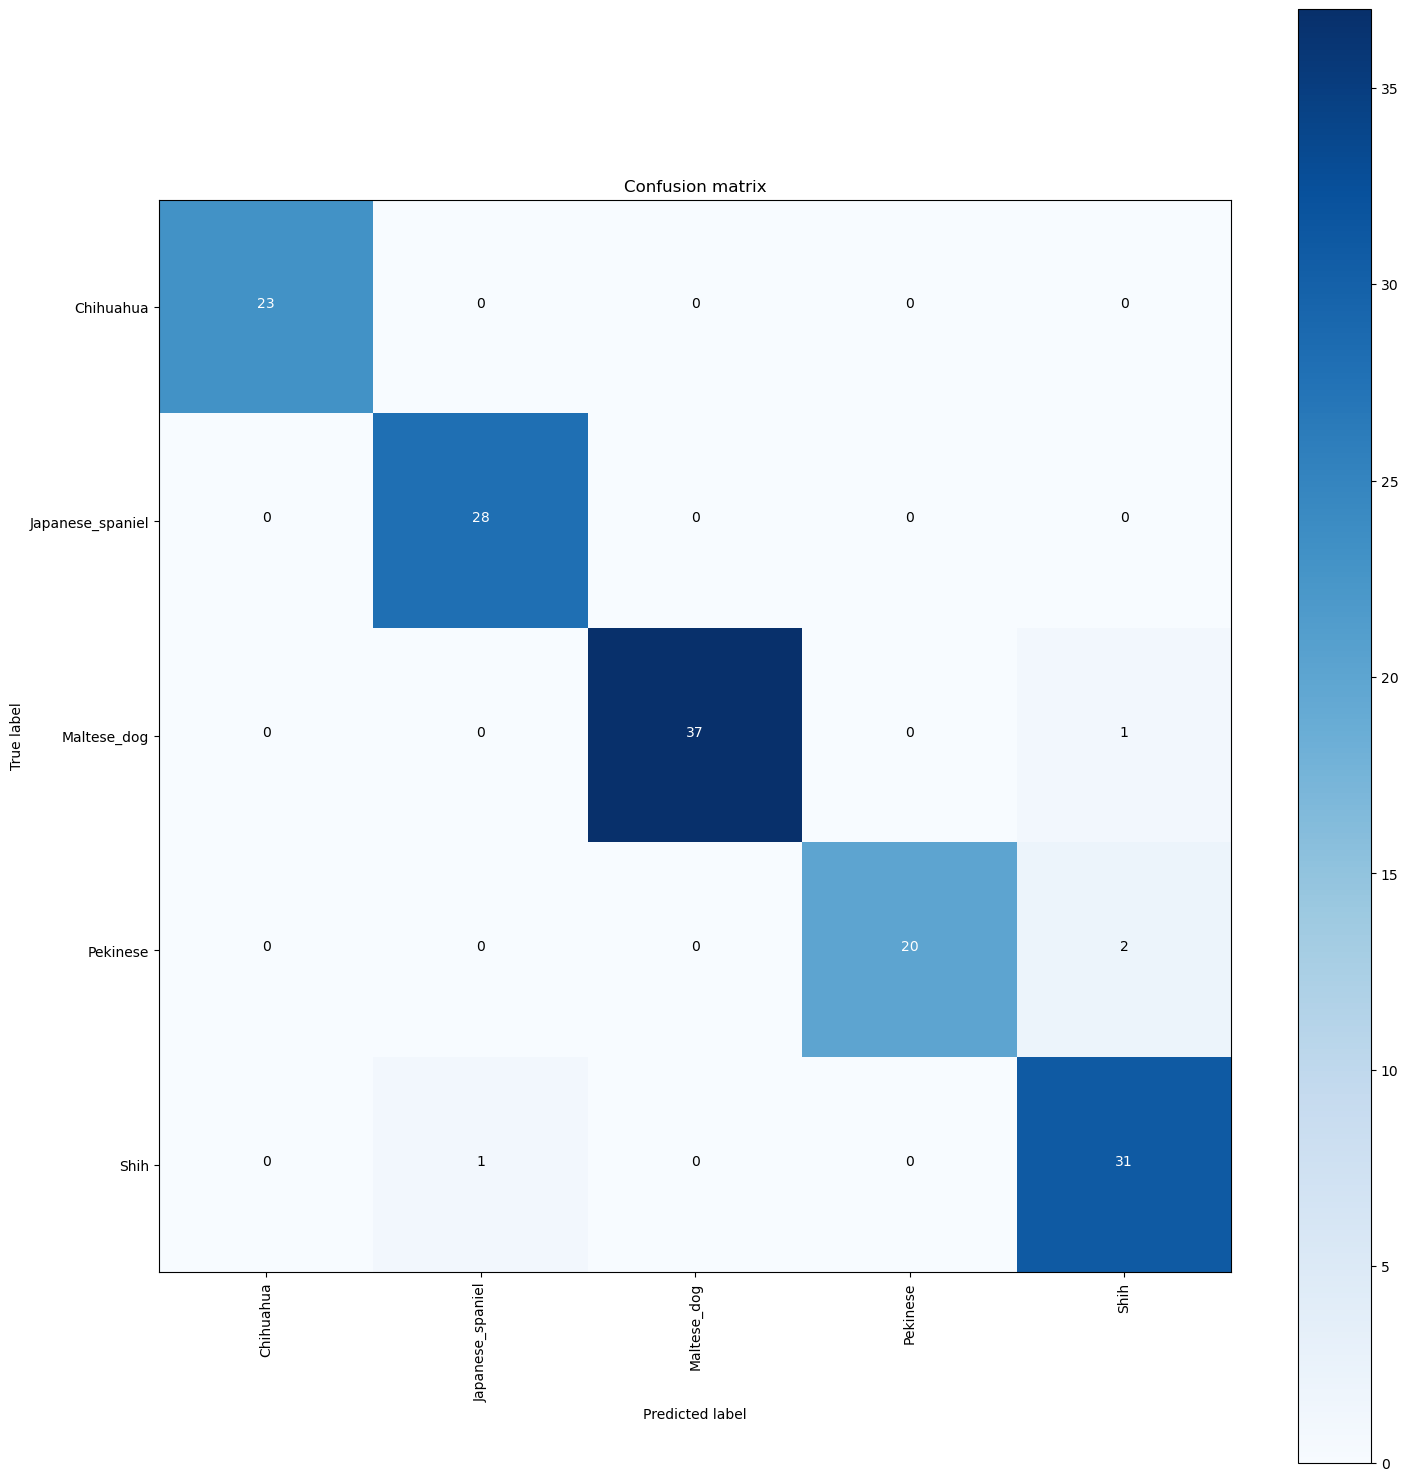

In [49]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [50]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [51]:
conv_base = InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [52]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1016 (Conv2D)            (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1016 (Batch (None, 149, 149, 32) 96          conv2d_1016[0][0]                
__________________________________________________________________________________________________
activation_1016 (Activation)    (None, 149, 149, 32) 0           batch_normalization_1016[0][0]   
________________________________________________________________________________

In [53]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 1536))
test_features = np.reshape(test_features, (-1, 8 * 8 * 1536))

In [54]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_InceptionResNetV2_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_InceptionResNetV2_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 7072 samples, validate on 1527 samples
Epoch 1/1000
 - 16s - loss: 0.9082 - acc: 0.8380 - val_loss: 0.3829 - val_acc: 0.9365

Epoch 00001: val_loss improved from inf to 0.38286, saving model to tl_freeze_conv_base_InceptionResNetV2_60_breeds
Epoch 2/1000
 - 14s - loss: 0.5067 - acc: 0.9218 - val_loss: 0.4440 - val_acc: 0.9398

Epoch 00002: val_loss did not improve from 0.38286
Epoch 3/1000
 - 14s - loss: 0.3773 - acc: 0.9437 - val_loss: 0.4645 - val_acc: 0.9443

Epoch 00003: val_loss did not improve from 0.38286
Epoch 4/1000
 - 14s - loss: 0.2832 - acc: 0.9543 - val_loss: 0.4676 - val_acc: 0.9496

Epoch 00004: val_loss did not improve from 0.38286
Epoch 5/1000
 - 14s - loss: 0.2829 - acc: 0.9580 - val_loss: 0.3993 - val_acc: 0.9542

Epoch 00005: val_loss did not improve from 0.38286
Epoch 6/1000
 - 14s - loss: 0.1938 - acc: 0.9676 - val_loss: 0.4265 - val_acc: 0.9535

Epoch 00006: val_loss did not improve from 0.38286
Epoch 7/1000
 - 14s - loss: 0.1941 - acc: 0.9726 - val_loss

## Results

In [55]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 1s 894us/step


[0.539081062467953, 0.9153439402580261]

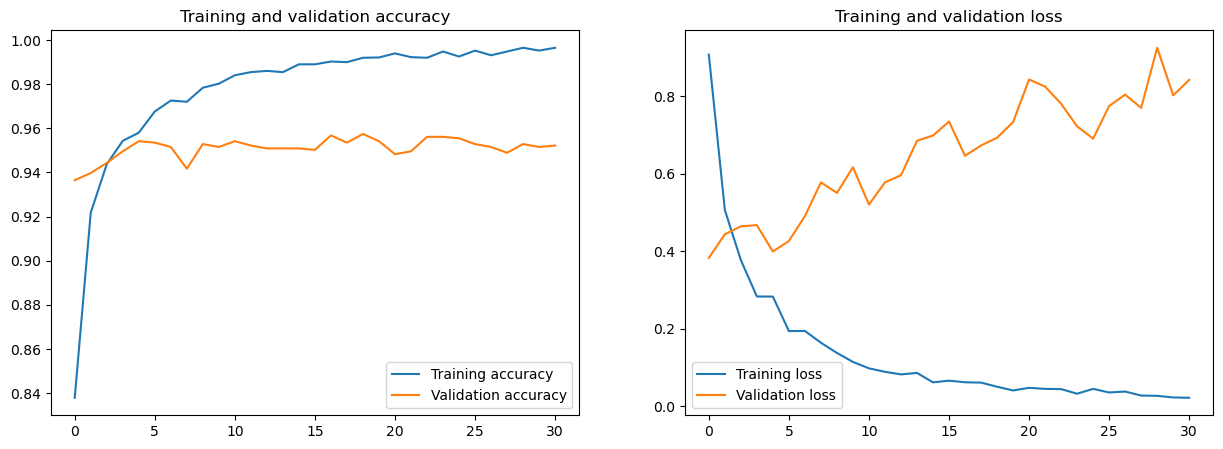

In [56]:
plot_accuracy_and_loss(history)

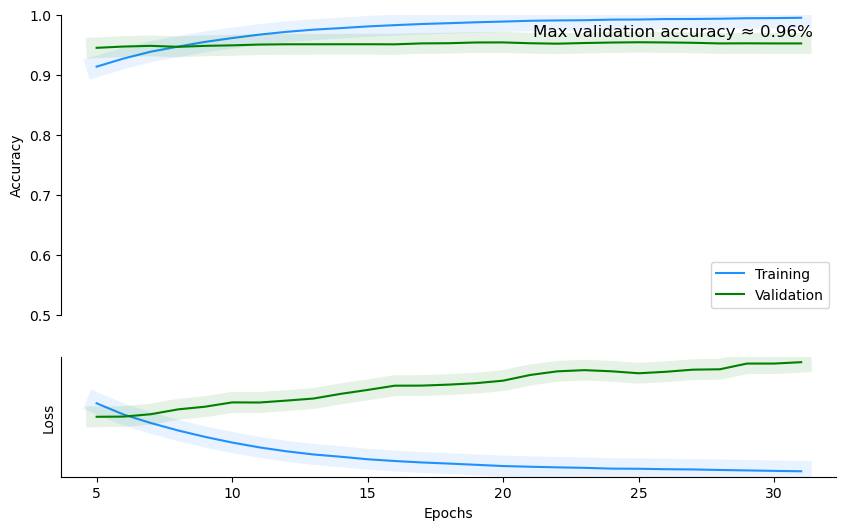

In [57]:
plot_history(history,xkcd=False)

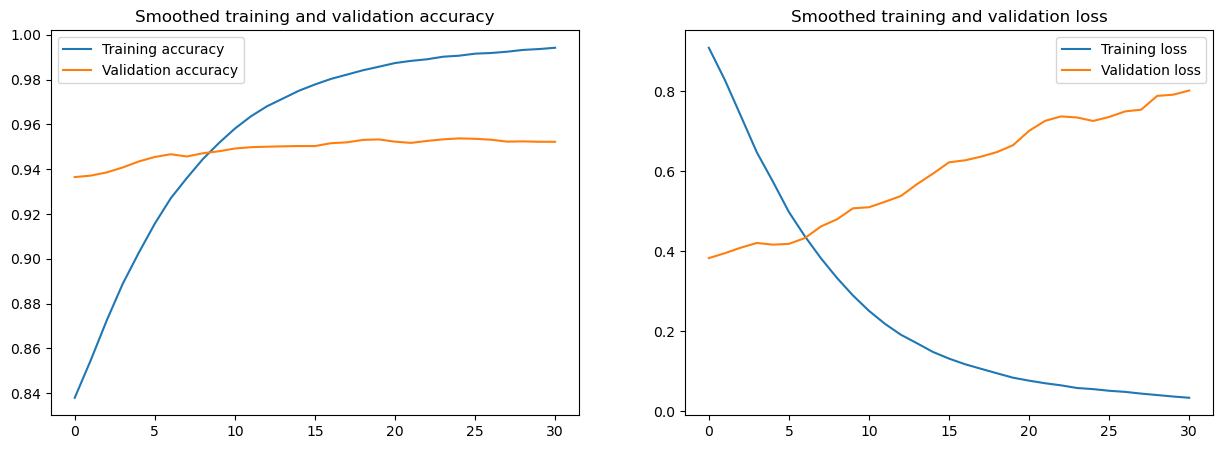

In [58]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

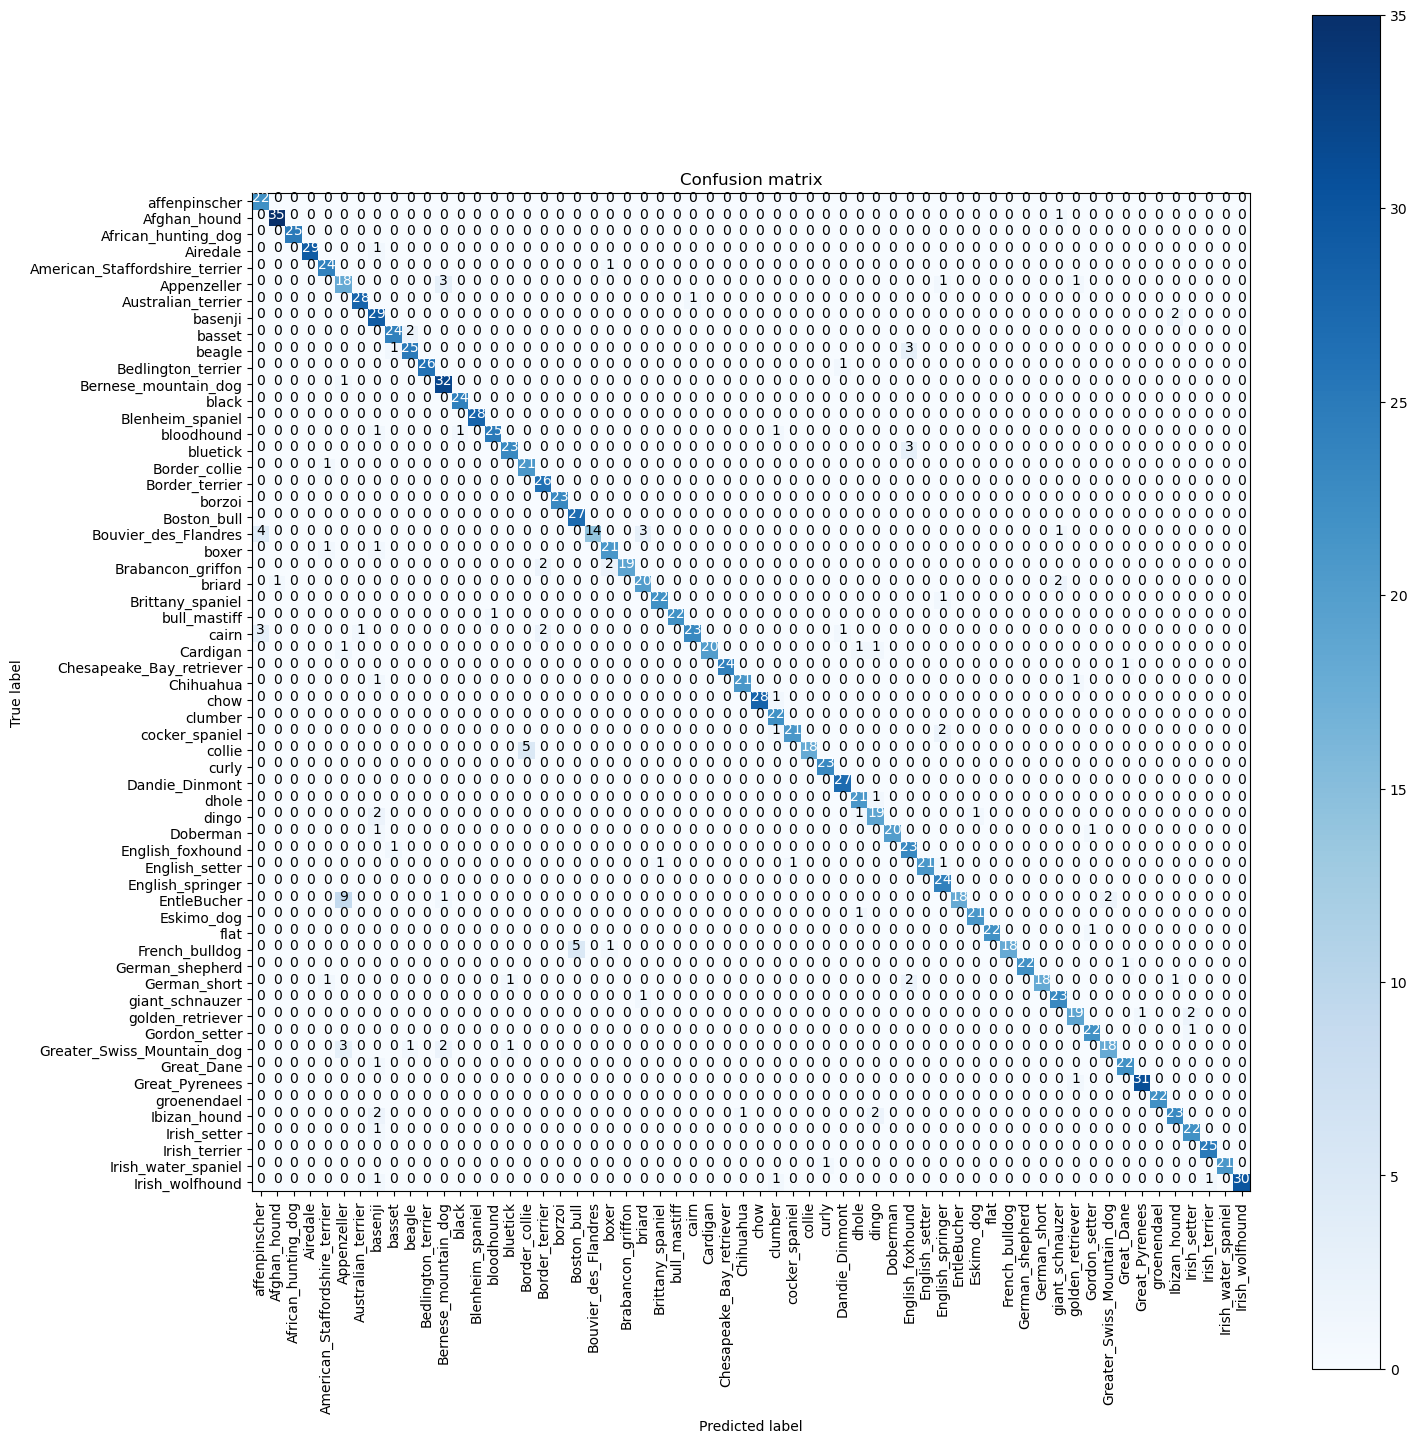

In [59]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [60]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [61]:
conv_base = InceptionResNetV2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [62]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1219 (Conv2D)            (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1219 (Batch (None, 149, 149, 32) 96          conv2d_1219[0][0]                
__________________________________________________________________________________________________
activation_1219 (Activation)    (None, 149, 149, 32) 0           batch_normalization_1219[0][0]   
________________________________________________________________________________

In [63]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 1536), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 1536))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 1536))
test_features = np.reshape(test_features, (-1, 8 * 8 * 1536))

In [64]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_InceptionResNetV2_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_InceptionResNetV2_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 14397 samples, validate on 3099 samples
Epoch 1/1000
 - 68s - loss: 1.2497 - acc: 0.7409 - val_loss: 0.3595 - val_acc: 0.9019

Epoch 00001: val_loss improved from inf to 0.35951, saving model to tl_freeze_conv_base_InceptionResNetV2_120_breeds
Epoch 2/1000
 - 60s - loss: 0.3635 - acc: 0.9040 - val_loss: 0.3373 - val_acc: 0.9074

Epoch 00002: val_loss improved from 0.35951 to 0.33730, saving model to tl_freeze_conv_base_InceptionResNetV2_120_breeds
Epoch 3/1000
 - 57s - loss: 0.2547 - acc: 0.9287 - val_loss: 0.3517 - val_acc: 0.9025

Epoch 00003: val_loss did not improve from 0.33730
Epoch 4/1000
 - 59s - loss: 0.1937 - acc: 0.9432 - val_loss: 0.3666 - val_acc: 0.9096

Epoch 00004: val_loss did not improve from 0.33730
Epoch 5/1000
 - 57s - loss: 0.1530 - acc: 0.9541 - val_loss: 0.3672 - val_acc: 0.9038

Epoch 00005: val_loss did not improve from 0.33730
Epoch 6/1000
 - 64s - loss: 0.1213 - acc: 0.9621 - val_loss: 0.3856 - val_acc: 0.9071

Epoch 00006: val_loss did not improve 

## Results

In [65]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 12s 4ms/step


[0.35689195399154483, 0.899156928062439]

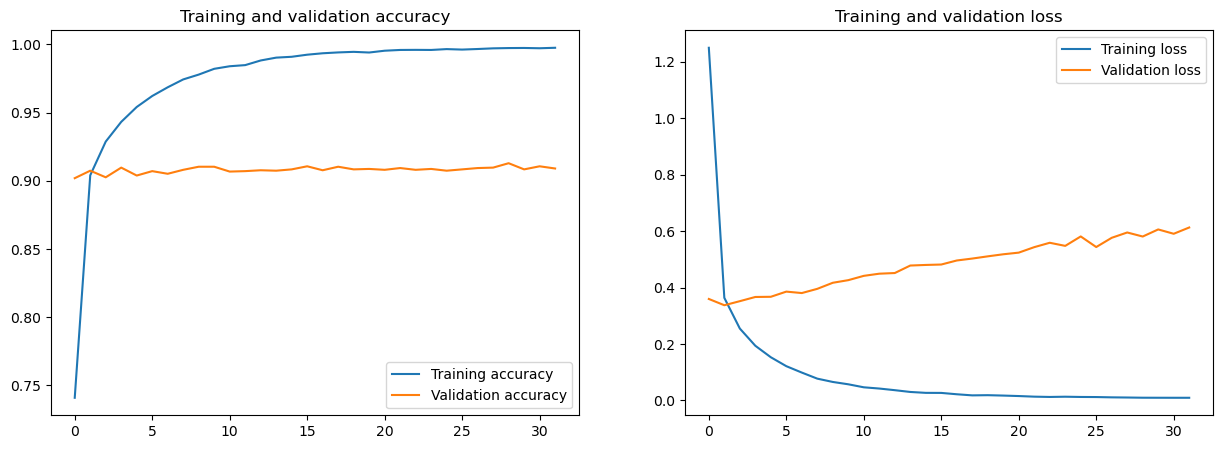

In [66]:
plot_accuracy_and_loss(history)

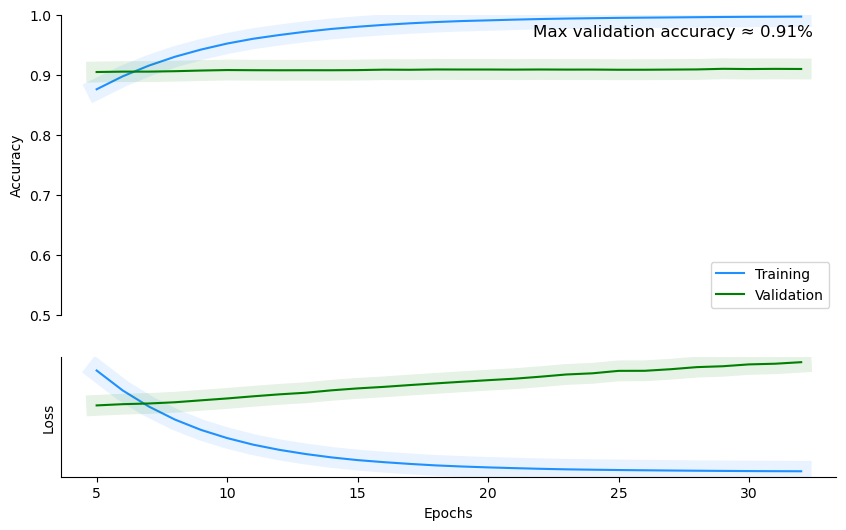

In [67]:
plot_history(history,xkcd=False)

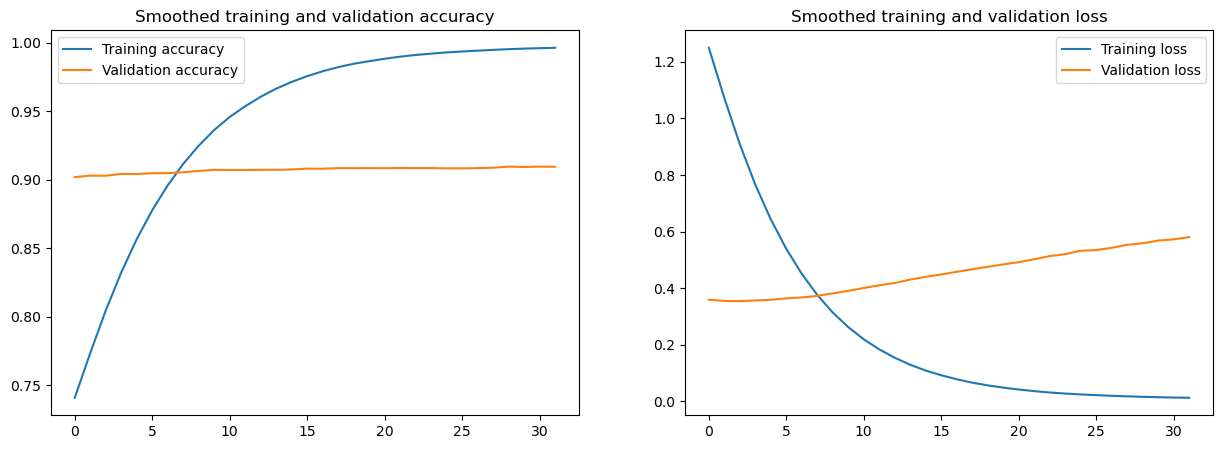

In [68]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

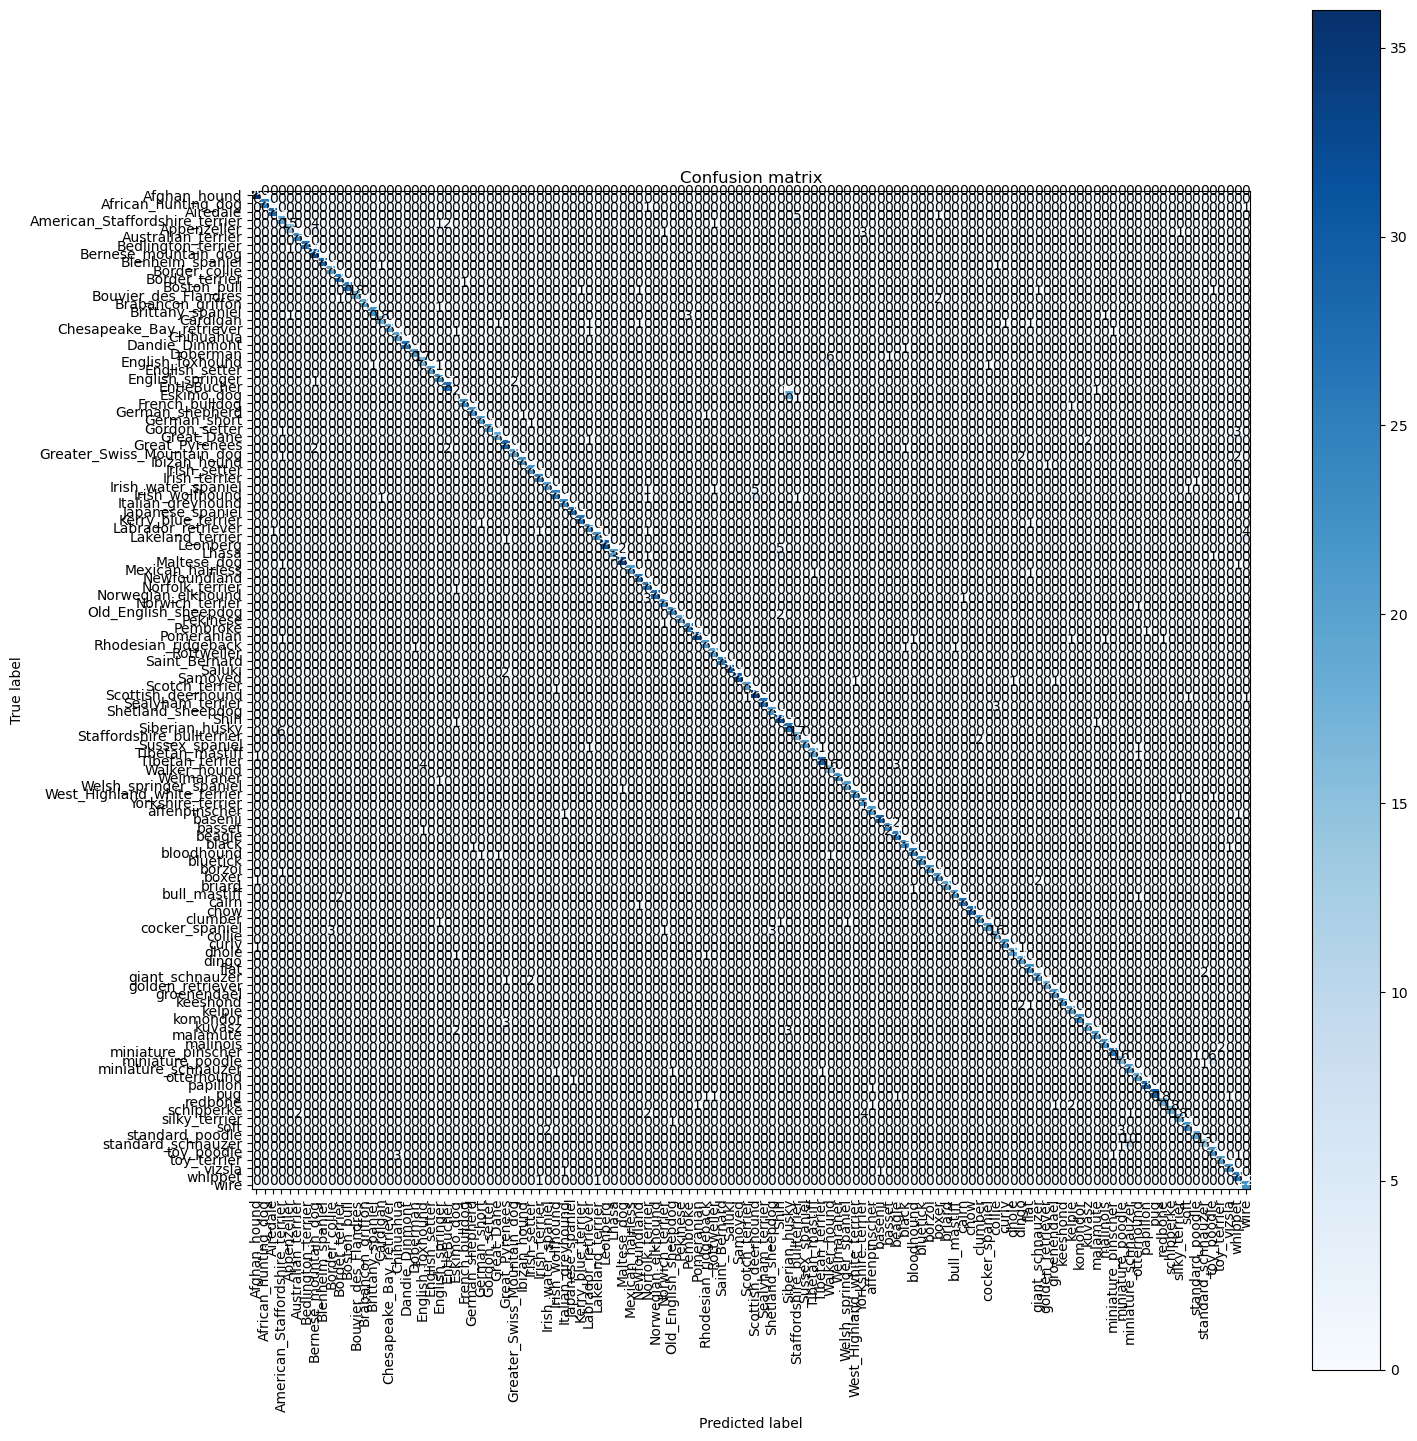

In [69]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()